**Import Tensorflow as Neural Network package**

In [175]:
import pandas as pd 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # take it out before handing in !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import tensorflow as tf

In [156]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.18.0


In [157]:
Data = pd.read_csv(r"C:\Users\maxd2\OneDrive - Universitaet St.Gallen\Dokumente\GitHub\Its-Wekk\4 - Data\Working_DataFrame.csv")
Target = pd.read_csv(r"C:\Users\maxd2\OneDrive - Universitaet St.Gallen\Dokumente\GitHub\Its-Wekk\5 - Models\Neural_Network\Data\Final_Target_Data_Combined_resid_Trend.csv")

In [158]:
Target.head()

Data.drop(columns = ['Datum'], inplace = True)
Data.head()


,Rebgassechange,Clarahuuschange,Citychange,Storchenchange,Post Baselchange,Aeschenchange,Bahnhof Südchange,Bad. Bahnhofchange,Europechange,Claramattechange,...,84111104v_sumPW,84111104v_sumLief,84111104v_sumLW,84111108n_sumPW,84111108n_sumLief,84111108n_sumLW,84111108v_sumPW,84111108v_sumLief,84111108v_sumLW,Gasverbrauch
0,-0.489808,-1.162325,-0.163786,-1.110112,-0.000054,-0.258093,-0.245491,-0.158272,-0.151270,-1.607696,...,-1.36395,1.425346,-0.124348,-0.686018,-0.571421,-1.055084,-0.814853,-0.416962,-1.072471,0.294494
1,-0.489808,-0.193898,-0.043944,-0.525891,-0.191296,-0.000173,-0.000190,-0.000462,-0.000203,-0.000156,...,-1.36395,0.745474,-0.744920,-0.955306,-0.781539,-1.055084,-1.048762,-0.773270,-1.072471,0.357518
2,-0.279837,-0.000213,-0.011259,-0.058515,-0.000054,-0.000173,-0.122840,-0.000462,-0.000203,-0.000156,...,-1.36395,0.575505,-0.744920,-0.937353,-0.571421,-1.055084,-1.057758,-0.416962,-1.072471,0.385414
3,-0.209846,-0.000213,-0.011259,-0.350625,-0.000054,-0.000173,-0.000190,-0.000462,-0.000203,-0.000156,...,-1.36395,0.269563,-0.744920,-1.045068,-0.571421,-1.055084,-1.201702,-0.416962,-1.072471,0.617131
4,-0.139856,-0.000213,0.021425,0.116751,-0.000054,-0.000173,0.245112,-0.000462,0.150864,-0.000156,...,-1.36395,0.575505,-0.331206,-1.063021,-0.781539,-1.055084,-1.255681,-0.654501,-1.072471,1.109860


In [159]:
#Lag Feature einbauen, da die Feinstaubkonzentration häufig von den Werten der letzten Tage abhängt 
lag_hours = 24

# Erstelle für jede Stunde in der Vergangenheit eine Lag-Feature-Spalte
for lag in range(1, lag_hours + 1):  
    Data[f'Feature_lag_{lag}'] = Target['PM10_Combined_Trend_Residual'].shift(lag)

# Entfernen von Zeilen mit NaN-Werten, die durch das Verschieben der Daten entstehen
Data.dropna(inplace=True)
# Stelle sicher, dass du NaN-Werte aus beiden X und y entfernst

# Stelle sicher, dass Target denselben Index hat wie Data
Target = Target.loc[Data.index]



In [160]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Data = scaler.fit_transform(Data)

In [161]:
# Beispiel: Annahme, X.shape[0] = 1000 (1000 Zeitpunkte)
n = Data.shape[0]
X = Data.copy()
y = Target["PM10_Combined_Trend_Residual"].copy()

# Split-Größen definieren
train_size = int(n * 0.7)  # 70% Training
val_size = int(n * 0.2)    # 20% Validierung
test_size = n - train_size - val_size  # 10% Test

# Training (älteste Daten)
X_train, y_train = X[:train_size], y[:train_size]

# Validierung (neuere Daten)
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]

# Test (neueste Daten)
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


In [162]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [163]:
optimizer = Adam(learning_rate=0.002)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [164]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=20,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

In [165]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=64, callbacks=[early_stopping])


Epoch 1/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 45.1424 - mae: 4.5204 - mse: 43.0480 - val_loss: 23.9363 - val_mae: 2.7677 - val_mse: 21.9004
Epoch 2/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.8184 - mae: 2.3363 - mse: 10.8158 - val_loss: 23.5143 - val_mae: 2.8485 - val_mse: 21.6085
Epoch 3/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.5308 - mae: 2.2010 - mse: 9.6550 - val_loss: 25.6169 - val_mae: 3.0321 - val_mse: 23.8308
Epoch 4/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.7341 - mae: 2.1454 - mse: 9.9752 - val_loss: 26.9676 - val_mae: 3.3020 - val_mse: 25.2974
Epoch 5/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.7390 - mae: 2.0637 - mse: 9.0940 - val_loss: 23.7759 - val_mae: 2.8864 - val_mse: 22.2103
Epoch 6/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.2807 - mae: 2.0006 - mse: 9.7366 - val_loss: 22.5395 - val_mae: 2.7505 - val_mse: 21.0700
Epoch 7/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.1340 - mae:

In [166]:
print(X_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in X_test
print(y_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in y_test


(2455, 172)
(2455,)


In [167]:
results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 6.4641 - mae: 1.7532 - mse: 5.6876
Test loss, Test MAE: [6.938469886779785, 1.802767038345337, 6.1619977951049805]


In [168]:
model2 = Sequential([
    Dense(512, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.005)),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.0015)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=15,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=64, callbacks=[early_stopping])

results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 44.9092 - mae: 4.3710 - mse: 43.6052 - val_loss: 21.8295 - val_mae: 2.6568 - val_mse: 20.5449
Epoch 2/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11.0782 - mae: 2.1772 - mse: 9.8046 - val_loss: 19.9190 - val_mae: 2.5083 - val_mse: 18.6803
Epoch 3/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.4304 - mae: 2.0218 - mse: 8.2045 - val_loss: 20.8532 - val_mae: 2.6913 - val_mse: 19.6577
Epoch 4/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.6697 - mae: 2.1069 - mse: 8.4843 - val_loss: 19.7614 - val_mae: 2.5696 - val_mse: 18.6117
Epoch 5/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0881 - mae: 1.9649 - mse: 7.9516 - val_loss: 18.1119 - val_mae: 2.3826 - val_mse: 17.0069
Epoch 6/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0566 - mae: 1.9854 - mse: 7.9614 - val_loss: 17.5725 - val_mae: 2.2416 - val_mse: 16.5167
Epoch 7/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.2525 - mae: 1.9664 - mse: 8.

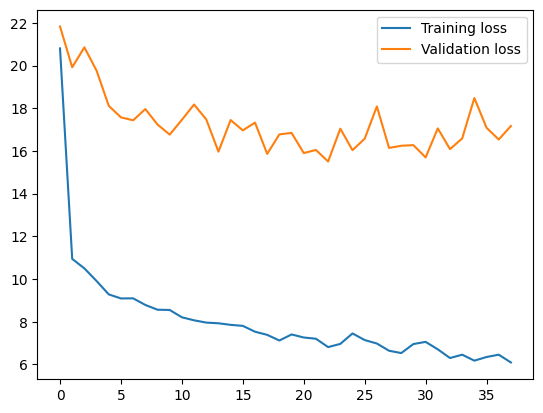

In [169]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [174]:
model3 = Sequential([
    Dense(512, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.15),
    Dense(256, activation='relu'),
    Dropout(0.38),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=38,  # Training stoppt, wenn sich der Validierungs-Loss 15 Epochen lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.38, patience=10, min_lr=1e-6)



history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping, lr_scheduler])

results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)

Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 32.2016 - mae: 3.4402 - mse: 26.3055 - val_loss: 27.0133 - val_mae: 3.0104 - val_mse: 23.1089 - learning_rate: 0.0010
Epoch 2/800
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 13.9698 - mae: 2.2980 - mse: 10.5325 - val_loss: 21.2748 - val_mae: 2.5256 - val_mse: 18.9127 - learning_rate: 0.0010
Epoch 3/800
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.8297 - mae: 2.1854 - mse: 10.6629 - val_loss: 18.4240 - val_mae: 2.2506 - val_mse: 16.8011 - learning_rate: 0.0010
Epoch 4/800
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11.0006 - mae: 2.1330 - mse: 9.4836 - val_loss: 19.5036 - val_mae: 2.4543 - val_mse: 18.2422 - learning_rate: 0.0010
Epoch 5/800
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 13.8522 - mae: 2.2237 - mse: 12.6060 - val_loss: 19.5559 - val_mae: 2.5234 - val_mse: 18.5059 - learning_rate: 0.0010
Epoch 6/800
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.2346 - mae: 1.9995 - mse: 8.2284 - val_loss

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7661 - mae: 1.4841 - mse: 4.2201  
Test loss, Test MAE: [5.42454195022583, 1.6282896995544434, 4.878493785858154]

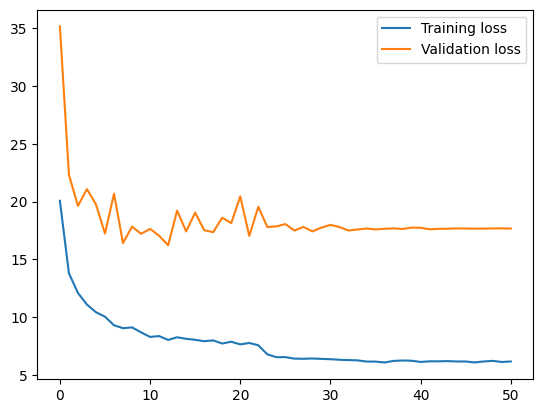

In [173]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


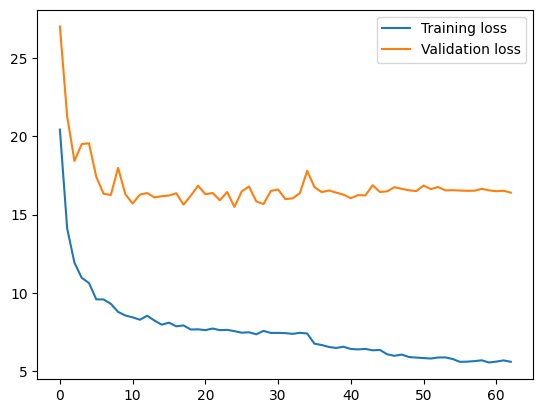

In [177]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [176]:

print("Available GPUs:", tf.config.list_physical_devices('GPU'))


Available GPUs: []
